In [ ]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [ ]:
# !ls -1ha kaggle.json

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [3]:
!pip3 install tokenizers wandb sentencepiece

     |████████████████████████████████| 6.6 MB 15.5 MB/s 
     |████████████████████████████████| 1.8 MB 74.6 MB/s 
     |████████████████████████████████| 1.2 MB 68.5 MB/s 
     |████████████████████████████████| 145 kB 86.0 MB/s 
     |████████████████████████████████| 181 kB 87.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=fc92b45979ae910384606c15076e261303818ee65d4b4477139e97ead15cb8ed
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [4]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 14.2 MB/s 
     |████████████████████████████████| 596 kB 79.2 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [6]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [7]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [8]:
OUTPUT_DIR = './pppm-pcc-outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 21 03:08:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=5
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=10
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [11]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-pcc', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [12]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [13]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)


# Data Loading

In [14]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [15]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [16]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

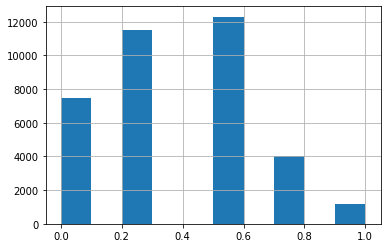

In [17]:
train['score'].hist()

In [18]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [19]:
# # ====================================================
# # CV split
# # ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [20]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [21]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [22]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [23]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [24]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

# Model

In [25]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output


In [26]:
# !pip install audtorch

# from audtorch.metrics.functional import pearsonr

In [27]:
# Pearson Correlation Coefficient
class PCCLoss(nn.Module):
    def __init__(self, reduction='none'):
        super().__init__()
        self.reduction = reduction
        self.cos = nn.CosineSimilarity()

    def std(self, input_tensor):
        return torch.std(input_tensor)

    def covariance_pcc(self, x, y):
        input_tensor = torch.stack([x, y])
        print(input_tensor)
        torch.flatten(input_tensor)
        return torch.cov(input_tensor)

    def covariance(self, x, y):
        x = x - torch.mean(x)
        y = y - torch.mean(y)
        try:
            x = torch.reshape(x, (1, 10))
            y = torch.reshape(y, (1, 10))
            return self.cos(x, y)
        except:
            x = torch.reshape(x, (1, 2))
            y = torch.reshape(y, (1, 2))
            return self.cos(x, y)

    def calculate_pcc(self, x, y):
        '''
        Reference: <https://www.kaggle.com/competitions/ubiquant-market-prediction/discussion/302977>
        '''
        log_mean = torch.mean(x)
        lab_mean = torch.mean(y)
        num = torch.sum(torch.mul((x - log_mean),(y - lab_mean)))

        pred_std = torch.sum(torch.square((x - log_mean)))
        label_std = torch.sum(torch.square((y - lab_mean)))
        den = torch.sqrt(pred_std * label_std)
        loss = -torch.divide(num, den)
        
        return loss

    
    def forward(self, inputs, targets):
        x = inputs
        y = targets

        loss = self.calculate_pcc(x, y)

        # stdx = self.std(x)
        # stdy = self.std(y)
        # loss = self.covariance(x, y)
        # loss = torch.abs(loss)
        return loss


# Helper Functions

In [28]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        # loss = criterion_focal_loss(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        # preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [29]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    # criterion = FocalLossV1(alpha=CFG.alpha, gamma=CFG.gamma, reduction=CFG.focal_reduction).cuda()
    # criterion1 = FocalLossWithSmoothing(5, gamma=CFG.gamma, lb_smooth=CFG.lb_smooth, alpha=CFG.alpha)
    # criterion = LabelSmoothSoftmaxCE(lb_smooth=CFG.lb_smooth, loss_func=criterion1)
    criterion = PCCLoss(reduction='mean').cuda()
    # criterion = F.mse_loss

    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [30]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2888] Elapsed 0m 0s (remain 38m 45s) Loss: -0.2239(-0.2239) Grad: nan  LR: 0.00002000  
Epoch: [1][100/2888] Elapsed 0m 26s (remain 12m 17s) Loss: -0.6391(-0.4145) Grad: 9226.7666  LR: 0.00002000  
Epoch: [1][200/2888] Elapsed 0m 52s (remain 11m 36s) Loss: -0.8607(-0.5274) Grad: 6747.1895  LR: 0.00001999  
Epoch: [1][300/2888] Elapsed 1m 17s (remain 11m 7s) Loss: -0.4928(-0.5660) Grad: 19855.8906  LR: 0.00001998  
Epoch: [1][400/2888] Elapsed 1m 42s (remain 10m 38s) Loss: -0.4459(-0.5906) Grad: 12510.7783  LR: 0.00001996  
Epoch: [1][500/2888] Elapsed 2m 8s (remain 10m 13s) Loss: -0.9307(-0.6223) Grad: 2989.2405  LR: 0.00001994  
Epoch: [1][600/2888] Elapsed 2m 34s (remain 9m 47s) Loss: -0.6906(-0.6407) Grad: 5548.5620  LR: 0.00001991  
Epoch: [1][700/2888] Elapsed 3m 0s (remain 9m 22s) Loss: -0.7468(-0.6565) Grad: 6228.0098  LR: 0.00001988  
Epoch: [1][800/2888] Elapsed 3m 25s (remain 8m 56s) Loss: -0.5177(-0.6645) Grad: 17131.3184  LR: 0.00001985  
Epoch: [1][900/2888] E

Epoch 1 - avg_train_loss: -0.7528  avg_val_loss: nan  time: 820s
Epoch 1 - Score: 0.7874
Epoch 1 - Save Best Score: 0.7874 Model


EVAL: [759/760] Elapsed 1m 20s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [2][0/2888] Elapsed 0m 0s (remain 28m 16s) Loss: -0.9767(-0.9767) Grad: 69958.2031  LR: 0.00001809  
Epoch: [2][100/2888] Elapsed 0m 27s (remain 12m 31s) Loss: -0.9224(-0.8768) Grad: 19822.7852  LR: 0.00001796  
Epoch: [2][200/2888] Elapsed 0m 53s (remain 11m 52s) Loss: -0.9302(-0.8727) Grad: 21145.8359  LR: 0.00001783  
Epoch: [2][300/2888] Elapsed 1m 18s (remain 11m 16s) Loss: -0.8705(-0.8732) Grad: 75491.5234  LR: 0.00001769  
Epoch: [2][400/2888] Elapsed 1m 44s (remain 10m 47s) Loss: -0.9736(-0.8759) Grad: 9639.9990  LR: 0.00001755  
Epoch: [2][500/2888] Elapsed 2m 10s (remain 10m 19s) Loss: -0.9093(-0.8744) Grad: 27845.6973  LR: 0.00001740  
Epoch: [2][600/2888] Elapsed 2m 35s (remain 9m 52s) Loss: -0.9790(-0.8763) Grad: 8072.8540  LR: 0.00001725  
Epoch: [2][700/2888] Elapsed 3m 1s (remain 9m 25s) Loss: -0.8924(-0.8753) Grad: 26719.6270  LR: 0.00001710  
Epoch: [2][800/2888] Elapsed 3m 26s (remain 8m 59s) Lo

Epoch 2 - avg_train_loss: -0.8776  avg_val_loss: nan  time: 822s
Epoch 2 - Score: 0.8012
Epoch 2 - Save Best Score: 0.8012 Model


EVAL: [759/760] Elapsed 1m 20s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [3][0/2888] Elapsed 0m 0s (remain 27m 4s) Loss: -0.9068(-0.9068) Grad: 307048.1250  LR: 0.00001309  
Epoch: [3][100/2888] Elapsed 0m 27s (remain 12m 30s) Loss: -0.8178(-0.9187) Grad: 65228.4141  LR: 0.00001288  
Epoch: [3][200/2888] Elapsed 0m 53s (remain 11m 50s) Loss: -0.6673(-0.9184) Grad: 111457.4219  LR: 0.00001267  
Epoch: [3][300/2888] Elapsed 1m 18s (remain 11m 15s) Loss: -0.9687(-0.9193) Grad: 35127.6133  LR: 0.00001246  
Epoch: [3][400/2888] Elapsed 1m 43s (remain 10m 44s) Loss: -0.8950(-0.9182) Grad: 38209.7227  LR: 0.00001225  
Epoch: [3][500/2888] Elapsed 2m 9s (remain 10m 17s) Loss: -0.9163(-0.9177) Grad: 17852.0918  LR: 0.00001204  
Epoch: [3][600/2888] Elapsed 2m 34s (remain 9m 49s) Loss: -0.9567(-0.9143) Grad: 10439.3984  LR: 0.00001182  
Epoch: [3][700/2888] Elapsed 3m 0s (remain 9m 22s) Loss: -0.4496(-0.9136) Grad: 381801.0938  LR: 0.00001161  
Epoch: [3][800/2888] Elapsed 3m 25s (remain 8m 55s)

Epoch 3 - avg_train_loss: nan  avg_val_loss: nan  time: 817s
Epoch 3 - Score: 0.8033
Epoch 3 - Save Best Score: 0.8033 Model


EVAL: [759/760] Elapsed 1m 20s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [4][0/2888] Elapsed 0m 0s (remain 33m 12s) Loss: -0.9684(-0.9684) Grad: 64890.4688  LR: 0.00000691  
Epoch: [4][100/2888] Elapsed 0m 27s (remain 12m 28s) Loss: -0.9788(-0.9374) Grad: 17029.9902  LR: 0.00000670  
Epoch: [4][200/2888] Elapsed 0m 53s (remain 11m 54s) Loss: -0.9622(-0.9389) Grad: 12536.1338  LR: 0.00000650  
Epoch: [4][300/2888] Elapsed 1m 19s (remain 11m 21s) Loss: -0.9635(-0.9356) Grad: 11211.4434  LR: 0.00000629  
Epoch: [4][400/2888] Elapsed 1m 44s (remain 10m 51s) Loss: -0.9539(-0.9332) Grad: 14645.0410  LR: 0.00000609  
Epoch: [4][500/2888] Elapsed 2m 10s (remain 10m 23s) Loss: -0.9782(-0.9332) Grad: 9586.5879  LR: 0.00000589  
Epoch: [4][600/2888] Elapsed 2m 36s (remain 9m 55s) Loss: -0.9481(-0.9353) Grad: 5899.4502  LR: 0.00000570  
Epoch: [4][700/2888] Elapsed 3m 2s (remain 9m 28s) Loss: -0.9865(-0.9353) Grad: 11291.6875  LR: 0.00000550  
Epoch: [4][800/2888] Elapsed 3m 28s (remain 9m 2s) Los

Epoch 4 - avg_train_loss: -0.9399  avg_val_loss: nan  time: 821s
Epoch 4 - Score: 0.8081
Epoch 4 - Save Best Score: 0.8081 Model


EVAL: [759/760] Elapsed 1m 20s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [5][0/2888] Elapsed 0m 0s (remain 32m 36s) Loss: -0.9282(-0.9282) Grad: 109602.9766  LR: 0.00000191  
Epoch: [5][100/2888] Elapsed 0m 27s (remain 12m 39s) Loss: -0.9547(-0.9527) Grad: 62009.8633  LR: 0.00000178  
Epoch: [5][200/2888] Elapsed 0m 54s (remain 12m 4s) Loss: -0.9755(-0.9585) Grad: 17108.8809  LR: 0.00000166  
Epoch: [5][300/2888] Elapsed 1m 19s (remain 11m 23s) Loss: -0.9838(-0.9602) Grad: 20842.2402  LR: 0.00000154  
Epoch: [5][400/2888] Elapsed 1m 44s (remain 10m 50s) Loss: -0.9958(-0.9544) Grad: 3260.7439  LR: 0.00000143  
Epoch: [5][500/2888] Elapsed 2m 10s (remain 10m 23s) Loss: -0.9786(-0.9550) Grad: 22597.5059  LR: 0.00000132  
Epoch: [5][600/2888] Elapsed 2m 36s (remain 9m 54s) Loss: -0.9120(-0.9538) Grad: 66509.8438  LR: 0.00000121  
Epoch: [5][700/2888] Elapsed 3m 1s (remain 9m 26s) Loss: -0.8953(-0.9537) Grad: 15018.2783  LR: 0.00000111  
Epoch: [5][800/2888] Elapsed 3m 26s (remain 8m 59s) L

Epoch 5 - avg_train_loss: -0.9551  avg_val_loss: nan  time: 814s
Epoch 5 - Score: 0.8080


EVAL: [759/760] Elapsed 1m 20s (remain 0m 0s) Loss: -1.0000(nan) 


========== fold: 0 result ==========
Score: 0.8081
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2947] Elapsed 0m 0s (remain 25m 30s) Loss: 0.5522(0.5522) Grad: nan  LR: 0.00002000  
Epoch: [1][100/2947] Elapsed 0m 25s (remain 11m 56s) Loss: -0.5560(-0.3320) Grad: 18793.6211  LR: 0.00002000  
Epoch: [1][200/2947] Elapsed 0m 50s (remain 11m 27s) Loss: -0.7846(-0.4685) Grad: 10215.6514  LR: 0.00001999  
Epoch: [1][300/2947] Elapsed 1m 15s (remain 11m 2s) Loss: -0.7779(-0.5453) Grad: 6444.6113  LR: 0.00001998  
Epoch: [1][400/2947] Elapsed 1m 40s (remain 10m 38s) Loss: -0.4605(-0.5761) Grad: 8116.4976  LR: 0.00001996  
Epoch: [1][500/2947] Elapsed 2m 5s (remain 10m 12s) Loss: -0.1464(-0.5932) Grad: 14198.9512  LR: 0.00001994  
Epoch: [1][600/2947] Elapsed 2m 30s (remain 9m 47s) Loss: -0.8232(-0.6131) Grad: 3475.7954  LR: 0.00001992  
Epoch: [1][700/2947] Elapsed 2m 55s (remain 9m 21s) Loss: -0.9069(-0.6354) Grad: 10956.7295  LR: 0.00001989  
Epoch: [1][800/2947] Elapsed 3m 20s (remain 8m 57s) Loss: -0.7786(-0.6473) Grad: 10789.8086  LR: 0.00001985  
Epoch: [1][900/2947] 

Epoch 1 - avg_train_loss: -0.7458  avg_val_loss: nan  time: 812s
Epoch 1 - Score: 0.8055
Epoch 1 - Save Best Score: 0.8055 Model


EVAL: [699/700] Elapsed 1m 13s (remain 0m 0s) Loss: -0.9439(nan) 
Epoch: [2][0/2947] Elapsed 0m 0s (remain 32m 31s) Loss: -0.9451(-0.9451) Grad: 72023.3672  LR: 0.00001809  
Epoch: [2][100/2947] Elapsed 0m 26s (remain 12m 34s) Loss: -0.8926(-0.8882) Grad: 140489.9062  LR: 0.00001796  
Epoch: [2][200/2947] Elapsed 0m 52s (remain 11m 54s) Loss: -0.9148(-0.8801) Grad: 24021.1914  LR: 0.00001783  
Epoch: [2][300/2947] Elapsed 1m 17s (remain 11m 21s) Loss: -0.9726(-0.8790) Grad: 8723.3262  LR: 0.00001770  
Epoch: [2][400/2947] Elapsed 1m 42s (remain 10m 51s) Loss: -0.9304(-0.8827) Grad: 24793.1016  LR: 0.00001756  
Epoch: [2][500/2947] Elapsed 2m 7s (remain 10m 24s) Loss: -0.8496(-0.8813) Grad: 32380.6914  LR: 0.00001742  
Epoch: [2][600/2947] Elapsed 2m 33s (remain 9m 58s) Loss: -0.5557(-0.8787) Grad: 77268.2500  LR: 0.00001727  
Epoch: [2][700/2947] Elapsed 2m 59s (remain 9m 33s) Loss: -0.9698(-0.8814) Grad: 13197.0645  LR: 0.00001713  
Epoch: [2][800/2947] Elapsed 3m 24s (remain 9m 7s) L

Epoch 2 - avg_train_loss: -0.8787  avg_val_loss: nan  time: 825s
Epoch 2 - Score: 0.8088
Epoch 2 - Save Best Score: 0.8088 Model


EVAL: [699/700] Elapsed 1m 14s (remain 0m 0s) Loss: -0.9140(nan) 
Epoch: [3][0/2947] Elapsed 0m 0s (remain 31m 29s) Loss: -0.9731(-0.9731) Grad: 75782.8984  LR: 0.00001309  
Epoch: [3][100/2947] Elapsed 0m 27s (remain 12m 52s) Loss: -0.7796(-0.9016) Grad: 77965.5234  LR: 0.00001289  
Epoch: [3][200/2947] Elapsed 0m 53s (remain 12m 8s) Loss: -0.9658(-0.9038) Grad: 21459.5312  LR: 0.00001268  
Epoch: [3][300/2947] Elapsed 1m 18s (remain 11m 33s) Loss: -0.9334(-0.9063) Grad: 46220.6992  LR: 0.00001248  
Epoch: [3][400/2947] Elapsed 1m 44s (remain 11m 3s) Loss: -0.9899(-0.9109) Grad: 23814.1094  LR: 0.00001227  
Epoch: [3][500/2947] Elapsed 2m 9s (remain 10m 33s) Loss: -0.8076(-0.9108) Grad: 125718.4844  LR: 0.00001206  
Epoch: [3][600/2947] Elapsed 2m 34s (remain 10m 4s) Loss: -0.9717(-0.9103) Grad: 16379.6045  LR: 0.00001185  
Epoch: [3][700/2947] Elapsed 3m 0s (remain 9m 37s) Loss: -0.8924(-0.9100) Grad: 38429.5312  LR: 0.00001164  
Epoch: [3][800/2947] Elapsed 3m 25s (remain 9m 10s) Lo

Epoch 3 - avg_train_loss: -0.9128  avg_val_loss: nan  time: 819s
Epoch 3 - Score: 0.8122
Epoch 3 - Save Best Score: 0.8122 Model


EVAL: [699/700] Elapsed 1m 14s (remain 0m 0s) Loss: -0.9859(nan) 
Epoch: [4][0/2947] Elapsed 0m 0s (remain 31m 48s) Loss: -0.9330(-0.9330) Grad: 99053.3984  LR: 0.00000691  
Epoch: [4][100/2947] Elapsed 0m 26s (remain 12m 39s) Loss: -0.9956(-0.9347) Grad: 5028.7573  LR: 0.00000671  
Epoch: [4][200/2947] Elapsed 0m 52s (remain 11m 57s) Loss: -0.9593(-0.9370) Grad: 37602.8477  LR: 0.00000651  
Epoch: [4][300/2947] Elapsed 1m 18s (remain 11m 29s) Loss: -0.9665(-0.9391) Grad: 14852.6348  LR: 0.00000631  
Epoch: [4][400/2947] Elapsed 1m 43s (remain 10m 57s) Loss: -0.7217(-0.9388) Grad: 23355.5391  LR: 0.00000611  
Epoch: [4][500/2947] Elapsed 2m 9s (remain 10m 32s) Loss: -0.9822(-0.9383) Grad: 7873.7026  LR: 0.00000592  
Epoch: [4][600/2947] Elapsed 2m 35s (remain 10m 6s) Loss: -0.9414(-0.9391) Grad: 26751.4590  LR: 0.00000572  
Epoch: [4][700/2947] Elapsed 3m 1s (remain 9m 40s) Loss: -0.9951(-0.9401) Grad: 4396.4785  LR: 0.00000553  
Epoch: [4][800/2947] Elapsed 3m 27s (remain 9m 15s) Loss

Epoch 4 - avg_train_loss: -0.9403  avg_val_loss: nan  time: 838s
Epoch 4 - Score: 0.8072


EVAL: [699/700] Elapsed 1m 14s (remain 0m 0s) Loss: -0.9762(nan) 
Epoch: [5][0/2947] Elapsed 0m 0s (remain 30m 0s) Loss: -0.9958(-0.9958) Grad: nan  LR: 0.00000191  
Epoch: [5][100/2947] Elapsed 0m 26s (remain 12m 30s) Loss: -0.9640(-0.9677) Grad: 33968.1680  LR: 0.00000179  
Epoch: [5][200/2947] Elapsed 0m 52s (remain 11m 58s) Loss: -0.9973(-0.9616) Grad: 1797.1937  LR: 0.00000167  
Epoch: [5][300/2947] Elapsed 1m 18s (remain 11m 30s) Loss: -0.9979(-0.9627) Grad: 3542.5488  LR: 0.00000155  
Epoch: [5][400/2947] Elapsed 1m 44s (remain 11m 0s) Loss: -0.9855(-0.9622) Grad: 12774.8877  LR: 0.00000144  
Epoch: [5][500/2947] Elapsed 2m 9s (remain 10m 31s) Loss: -0.9741(-0.9620) Grad: 23648.3730  LR: 0.00000133  
Epoch: [5][600/2947] Elapsed 2m 34s (remain 10m 4s) Loss: -0.9613(-0.9613) Grad: 18934.5664  LR: 0.00000123  
Epoch: [5][700/2947] Elapsed 3m 0s (remain 9m 38s) Loss: -0.9896(-0.9606) Grad: 11159.3535  LR: 0.00000113  
Epoch: [5][800/2947] Elapsed 3m 25s (remain 9m 10s) Loss: -0.918

Epoch 5 - avg_train_loss: -0.9567  avg_val_loss: nan  time: 830s
Epoch 5 - Score: 0.8072


EVAL: [699/700] Elapsed 1m 14s (remain 0m 0s) Loss: -0.9959(nan) 


========== fold: 1 result ==========
Score: 0.8122
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2879] Elapsed 0m 0s (remain 23m 51s) Loss: -0.1056(-0.1056) Grad: nan  LR: 0.00002000  
Epoch: [1][100/2879] Elapsed 0m 25s (remain 11m 51s) Loss: -0.5586(-0.3132) Grad: 20018.1934  LR: 0.00002000  
Epoch: [1][200/2879] Elapsed 0m 50s (remain 11m 17s) Loss: -0.6491(-0.4644) Grad: 4952.9907  LR: 0.00001999  
Epoch: [1][300/2879] Elapsed 1m 15s (remain 10m 50s) Loss: -0.7392(-0.5289) Grad: 18808.8750  LR: 0.00001998  
Epoch: [1][400/2879] Elapsed 1m 41s (remain 10m 24s) Loss: -0.6946(-0.5650) Grad: 25514.7734  LR: 0.00001996  
Epoch: [1][500/2879] Elapsed 2m 6s (remain 9m 59s) Loss: -0.7901(-0.5956) Grad: 11926.8174  LR: 0.00001994  
Epoch: [1][600/2879] Elapsed 2m 31s (remain 9m 36s) Loss: -0.8576(-0.6143) Grad: 15222.8662  LR: 0.00001991  
Epoch: [1][700/2879] Elapsed 2m 57s (remain 9m 10s) Loss: -0.3585(-0.6253) Grad: 18955.5547  LR: 0.00001988  
Epoch: [1][800/2879] Elapsed 3m 22s (remain 8m 45s) Loss: -0.1680(-0.6392) Grad: 61791.5742  LR: 0.00001985  
Epoch: [1][900/28

Epoch 1 - avg_train_loss: -0.7417  avg_val_loss: nan  time: 810s
Epoch 1 - Score: 0.8249
Epoch 1 - Save Best Score: 0.8249 Model


EVAL: [768/769] Elapsed 1m 21s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [2][0/2879] Elapsed 0m 0s (remain 26m 37s) Loss: -0.8880(-0.8880) Grad: nan  LR: 0.00001809  
Epoch: [2][100/2879] Elapsed 0m 26s (remain 12m 18s) Loss: -0.9399(-0.8579) Grad: 24181.3809  LR: 0.00001796  
Epoch: [2][200/2879] Elapsed 0m 52s (remain 11m 39s) Loss: -0.9114(-0.8683) Grad: 12862.9541  LR: 0.00001782  
Epoch: [2][300/2879] Elapsed 1m 17s (remain 11m 4s) Loss: -0.9377(-0.8658) Grad: 16215.9219  LR: 0.00001769  
Epoch: [2][400/2879] Elapsed 1m 42s (remain 10m 34s) Loss: -0.9434(-0.8660) Grad: 20726.2910  LR: 0.00001755  
Epoch: [2][500/2879] Elapsed 2m 7s (remain 10m 6s) Loss: -0.8887(-0.8707) Grad: 45639.8242  LR: 0.00001740  
Epoch: [2][600/2879] Elapsed 2m 32s (remain 9m 39s) Loss: -0.9675(-0.8707) Grad: 12573.5312  LR: 0.00001725  
Epoch: [2][700/2879] Elapsed 2m 57s (remain 9m 11s) Loss: -0.8796(-0.8695) Grad: 17868.2324  LR: 0.00001710  
Epoch: [2][800/2879] Elapsed 3m 22s (remain 8m 45s) Loss: -0.

Epoch 2 - avg_train_loss: -0.8776  avg_val_loss: nan  time: 807s
Epoch 2 - Score: 0.8279
Epoch 2 - Save Best Score: 0.8279 Model


EVAL: [768/769] Elapsed 1m 21s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [3][0/2879] Elapsed 0m 0s (remain 25m 36s) Loss: -0.9127(-0.9127) Grad: nan  LR: 0.00001309  
Epoch: [3][100/2879] Elapsed 0m 27s (remain 12m 30s) Loss: -0.9295(-0.9124) Grad: 33925.2266  LR: 0.00001288  
Epoch: [3][200/2879] Elapsed 0m 53s (remain 11m 49s) Loss: -0.7682(-0.9176) Grad: 78188.2656  LR: 0.00001267  
Epoch: [3][300/2879] Elapsed 1m 18s (remain 11m 12s) Loss: -0.9808(-0.9196) Grad: 34812.3828  LR: 0.00001246  
Epoch: [3][400/2879] Elapsed 1m 44s (remain 10m 43s) Loss: -0.9459(-0.9225) Grad: 20306.4863  LR: 0.00001225  
Epoch: [3][500/2879] Elapsed 2m 9s (remain 10m 13s) Loss: -0.9291(-0.9196) Grad: 44672.6914  LR: 0.00001203  
Epoch: [3][600/2879] Elapsed 2m 33s (remain 9m 43s) Loss: -0.9165(-0.9180) Grad: 32929.3711  LR: 0.00001182  
Epoch: [3][700/2879] Elapsed 2m 58s (remain 9m 15s) Loss: -0.9184(-0.9174) Grad: 16362.6611  LR: 0.00001160  
Epoch: [3][800/2879] Elapsed 3m 23s (remain 8m 48s) Loss: -

Epoch 3 - avg_train_loss: -0.9111  avg_val_loss: nan  time: 807s
Epoch 3 - Score: 0.8183


EVAL: [768/769] Elapsed 1m 21s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [4][0/2879] Elapsed 0m 0s (remain 27m 27s) Loss: -0.8548(-0.8548) Grad: 237235.1406  LR: 0.00000691  
Epoch: [4][100/2879] Elapsed 0m 25s (remain 11m 45s) Loss: -0.9978(-0.9327) Grad: 16166.4775  LR: 0.00000670  
Epoch: [4][200/2879] Elapsed 0m 51s (remain 11m 21s) Loss: -0.9132(-0.9332) Grad: 23151.7090  LR: 0.00000650  
Epoch: [4][300/2879] Elapsed 1m 16s (remain 10m 52s) Loss: -0.9901(-0.9370) Grad: 7728.8901  LR: 0.00000629  
Epoch: [4][400/2879] Elapsed 1m 41s (remain 10m 25s) Loss: -0.9790(-0.9369) Grad: 14617.6699  LR: 0.00000609  
Epoch: [4][500/2879] Elapsed 2m 6s (remain 9m 59s) Loss: -0.9823(-0.9392) Grad: 8988.1064  LR: 0.00000589  
Epoch: [4][600/2879] Elapsed 2m 31s (remain 9m 32s) Loss: -0.9788(-0.9402) Grad: 37986.5625  LR: 0.00000569  
Epoch: [4][700/2879] Elapsed 2m 55s (remain 9m 5s) Loss: -0.8888(-0.9418) Grad: 20831.4883  LR: 0.00000550  
Epoch: [4][800/2879] Elapsed 3m 20s (remain 8m 39s) Los

Epoch 4 - avg_train_loss: -0.9428  avg_val_loss: nan  time: 801s
Epoch 4 - Score: 0.8274


EVAL: [768/769] Elapsed 1m 21s (remain 0m 0s) Loss: -1.0000(nan) 
Epoch: [5][0/2879] Elapsed 0m 0s (remain 28m 5s) Loss: -0.9713(-0.9713) Grad: 185991.2188  LR: 0.00000191  
Epoch: [5][100/2879] Elapsed 0m 26s (remain 12m 6s) Loss: -0.9881(-0.9570) Grad: 21145.5039  LR: 0.00000178  
Epoch: [5][200/2879] Elapsed 0m 51s (remain 11m 23s) Loss: -0.9982(-0.9524) Grad: 2265.8750  LR: 0.00000166  
Epoch: [5][300/2879] Elapsed 1m 16s (remain 10m 51s) Loss: -0.9930(-0.9532) Grad: 11714.5420  LR: 0.00000154  
Epoch: [5][400/2879] Elapsed 1m 41s (remain 10m 25s) Loss: -0.9807(-0.9531) Grad: 33661.3789  LR: 0.00000143  
Epoch: [5][500/2879] Elapsed 2m 6s (remain 9m 59s) Loss: -0.9685(-0.9542) Grad: 19866.1992  LR: 0.00000132  
Epoch: [5][600/2879] Elapsed 2m 31s (remain 9m 34s) Loss: -0.9898(-0.9550) Grad: 10927.9736  LR: 0.00000121  
Epoch: [5][700/2879] Elapsed 2m 57s (remain 9m 10s) Loss: -0.9884(-0.9547) Grad: 9359.4141  LR: 0.00000111  
Epoch: [5][800/2879] Elapsed 3m 22s (remain 8m 44s) Loss

Epoch 5 - avg_train_loss: -0.9572  avg_val_loss: nan  time: 801s
Epoch 5 - Score: 0.8242


EVAL: [768/769] Elapsed 1m 21s (remain 0m 0s) Loss: -1.0000(nan) 


========== fold: 2 result ==========
Score: 0.8279
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2914] Elapsed 0m 0s (remain 23m 29s) Loss: -0.4197(-0.4197) Grad: nan  LR: 0.00002000  
Epoch: [1][100/2914] Elapsed 0m 25s (remain 11m 40s) Loss: -0.4403(-0.3513) Grad: 64174.6875  LR: 0.00002000  
Epoch: [1][200/2914] Elapsed 0m 49s (remain 11m 14s) Loss: -0.9007(-0.4821) Grad: 28030.2109  LR: 0.00001999  
Epoch: [1][300/2914] Elapsed 1m 14s (remain 10m 47s) Loss: -0.7180(-0.5431) Grad: 41058.1406  LR: 0.00001998  
Epoch: [1][400/2914] Elapsed 1m 39s (remain 10m 23s) Loss: -0.7458(-0.5736) Grad: 16262.6543  LR: 0.00001996  
Epoch: [1][500/2914] Elapsed 2m 4s (remain 10m 0s) Loss: -0.8352(-0.5928) Grad: 12399.9990  LR: 0.00001994  
Epoch: [1][600/2914] Elapsed 2m 29s (remain 9m 36s) Loss: -0.6115(-0.6117) Grad: 23153.1816  LR: 0.00001992  
Epoch: [1][700/2914] Elapsed 2m 54s (remain 9m 11s) Loss: -0.6000(-0.6233) Grad: 12570.1680  LR: 0.00001989  
Epoch: [1][800/2914] Elapsed 3m 19s (remain 8m 45s) Loss: -0.7376(-0.6340) Grad: 20924.6152  LR: 0.00001985  
Epoch: [1][900/2

Epoch 1 - avg_train_loss: -0.7140  avg_val_loss: nan  time: 810s
Epoch 1 - Score: 0.7707
Epoch 1 - Save Best Score: 0.7707 Model


EVAL: [732/733] Elapsed 1m 17s (remain 0m 0s) Loss: 0.4827(nan) 
Epoch: [2][0/2914] Elapsed 0m 0s (remain 28m 47s) Loss: -0.8672(-0.8672) Grad: 338921.8750  LR: 0.00001809  
Epoch: [2][100/2914] Elapsed 0m 26s (remain 12m 25s) Loss: -0.9656(-0.8300) Grad: 37945.7031  LR: 0.00001796  
Epoch: [2][200/2914] Elapsed 0m 52s (remain 11m 50s) Loss: -0.6153(-0.8249) Grad: 89707.3438  LR: 0.00001783  
Epoch: [2][300/2914] Elapsed 1m 17s (remain 11m 15s) Loss: -0.7227(-0.8268) Grad: 77018.8359  LR: 0.00001769  
Epoch: [2][400/2914] Elapsed 1m 43s (remain 10m 46s) Loss: -0.7205(-0.8228) Grad: 81676.2344  LR: 0.00001755  
Epoch: [2][500/2914] Elapsed 2m 8s (remain 10m 20s) Loss: -0.5785(-0.8197) Grad: 207131.6250  LR: 0.00001741  
Epoch: [2][600/2914] Elapsed 2m 33s (remain 9m 52s) Loss: -0.8919(-0.8209) Grad: 56768.6914  LR: 0.00001726  
Epoch: [2][700/2914] Elapsed 2m 59s (remain 9m 25s) Loss: -0.8131(-0.8247) Grad: 60738.3438  LR: 0.00001711  
Epoch: [2][800/2914] Elapsed 3m 24s (remain 8m 58s)

Epoch 2 - avg_train_loss: -0.8415  avg_val_loss: nan  time: 814s
Epoch 2 - Score: 0.7850
Epoch 2 - Save Best Score: 0.7850 Model


EVAL: [732/733] Elapsed 1m 17s (remain 0m 0s) Loss: 0.5426(nan) 
Epoch: [3][0/2914] Elapsed 0m 0s (remain 28m 19s) Loss: -0.9113(-0.9113) Grad: 155985.3438  LR: 0.00001309  
Epoch: [3][100/2914] Elapsed 0m 25s (remain 12m 0s) Loss: -0.9523(-0.8708) Grad: 21198.5781  LR: 0.00001289  
Epoch: [3][200/2914] Elapsed 0m 51s (remain 11m 31s) Loss: -0.8327(-0.8693) Grad: 29245.9707  LR: 0.00001268  
Epoch: [3][300/2914] Elapsed 1m 16s (remain 11m 2s) Loss: -0.9653(-0.8782) Grad: 17713.8203  LR: 0.00001247  
Epoch: [3][400/2914] Elapsed 1m 41s (remain 10m 34s) Loss: -0.9377(-0.8793) Grad: 21478.8926  LR: 0.00001226  
Epoch: [3][500/2914] Elapsed 2m 5s (remain 10m 6s) Loss: -0.8190(-0.8731) Grad: 307638.1250  LR: 0.00001205  
Epoch: [3][600/2914] Elapsed 2m 30s (remain 9m 40s) Loss: -0.9582(-0.8754) Grad: 37194.8711  LR: 0.00001184  
Epoch: [3][700/2914] Elapsed 2m 55s (remain 9m 15s) Loss: -0.3916(-0.8758) Grad: 64620.0742  LR: 0.00001163  
Epoch: [3][800/2914] Elapsed 3m 20s (remain 8m 50s) Lo

Epoch 3 - avg_train_loss: -0.8683  avg_val_loss: nan  time: 817s
Epoch 3 - Score: 0.8023
Epoch 3 - Save Best Score: 0.8023 Model


EVAL: [732/733] Elapsed 1m 17s (remain 0m 0s) Loss: -0.4714(nan) 
Epoch: [4][0/2914] Elapsed 0m 0s (remain 26m 53s) Loss: -0.8646(-0.8646) Grad: nan  LR: 0.00000691  
Epoch: [4][100/2914] Elapsed 0m 26s (remain 12m 20s) Loss: -0.8947(-0.8936) Grad: 45723.0938  LR: 0.00000671  
Epoch: [4][200/2914] Elapsed 0m 52s (remain 11m 52s) Loss: -0.9215(-0.8952) Grad: 34446.6875  LR: 0.00000651  
Epoch: [4][300/2914] Elapsed 1m 18s (remain 11m 19s) Loss: -0.9076(-0.8962) Grad: 49894.9648  LR: 0.00000630  
Epoch: [4][400/2914] Elapsed 1m 43s (remain 10m 48s) Loss: -0.8818(-0.8942) Grad: 19616.5059  LR: 0.00000611  
Epoch: [4][500/2914] Elapsed 2m 8s (remain 10m 18s) Loss: -0.8994(-0.8964) Grad: 20005.3906  LR: 0.00000591  
Epoch: [4][600/2914] Elapsed 2m 33s (remain 9m 49s) Loss: -0.6633(-0.9011) Grad: 29306.5332  LR: 0.00000571  
Epoch: [4][700/2914] Elapsed 2m 58s (remain 9m 23s) Loss: -0.8603(-0.9008) Grad: 27361.7520  LR: 0.00000552  
Epoch: [4][800/2914] Elapsed 3m 23s (remain 8m 57s) Loss: -

Epoch 4 - avg_train_loss: -0.9026  avg_val_loss: nan  time: 832s
Epoch 4 - Score: 0.8008


EVAL: [732/733] Elapsed 1m 17s (remain 0m 0s) Loss: -0.5083(nan) 
Epoch: [5][0/2914] Elapsed 0m 0s (remain 29m 10s) Loss: -0.8634(-0.8634) Grad: 144797.3750  LR: 0.00000191  
Epoch: [5][100/2914] Elapsed 0m 26s (remain 12m 15s) Loss: -0.9820(-0.9171) Grad: 25234.4355  LR: 0.00000179  
Epoch: [5][200/2914] Elapsed 0m 51s (remain 11m 39s) Loss: -0.9929(-0.9248) Grad: 9295.9297  LR: 0.00000167  
Epoch: [5][300/2914] Elapsed 1m 17s (remain 11m 10s) Loss: -0.9552(-0.9204) Grad: 50983.7617  LR: 0.00000155  
Epoch: [5][400/2914] Elapsed 1m 42s (remain 10m 43s) Loss: -0.9949(-0.9221) Grad: 3905.3650  LR: 0.00000144  
Epoch: [5][500/2914] Elapsed 2m 8s (remain 10m 19s) Loss: -0.7064(-0.9205) Grad: 82010.5156  LR: 0.00000133  
Epoch: [5][600/2914] Elapsed 2m 34s (remain 9m 53s) Loss: -0.9835(-0.9243) Grad: 5521.0864  LR: 0.00000122  
Epoch: [5][700/2914] Elapsed 2m 59s (remain 9m 28s) Loss: -0.9417(-0.9224) Grad: 25166.5137  LR: 0.00000112  
Epoch: [5][800/2914] Elapsed 3m 25s (remain 9m 2s) Los

Epoch 5 - avg_train_loss: -0.9228  avg_val_loss: nan  time: 823s
Epoch 5 - Score: 0.8009


EVAL: [732/733] Elapsed 1m 17s (remain 0m 0s) Loss: -0.2427(nan) 


========== fold: 3 result ==========
Score: 0.8023
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2959] Elapsed 0m 0s (remain 22m 57s) Loss: -0.2352(-0.2352) Grad: nan  LR: 0.00002000  
Epoch: [1][100/2959] Elapsed 0m 25s (remain 12m 4s) Loss: -0.8787(-0.3343) Grad: 19875.6660  LR: 0.00002000  
Epoch: [1][200/2959] Elapsed 0m 50s (remain 11m 33s) Loss: -0.8748(-0.4873) Grad: 6550.7666  LR: 0.00001999  
Epoch: [1][300/2959] Elapsed 1m 15s (remain 11m 9s) Loss: -0.2731(-0.5492) Grad: 11512.0703  LR: 0.00001998  
Epoch: [1][400/2959] Elapsed 1m 40s (remain 10m 42s) Loss: -0.8570(-0.5745) Grad: 4409.3760  LR: 0.00001996  
Epoch: [1][500/2959] Elapsed 2m 6s (remain 10m 18s) Loss: -0.6816(-0.5946) Grad: 4016.1587  LR: 0.00001994  
Epoch: [1][600/2959] Elapsed 2m 31s (remain 9m 52s) Loss: -0.7095(-0.6174) Grad: 6493.6450  LR: 0.00001992  
Epoch: [1][700/2959] Elapsed 2m 56s (remain 9m 28s) Loss: -0.9487(-0.6345) Grad: 3084.6821  LR: 0.00001989  
Epoch: [1][800/2959] Elapsed 3m 22s (remain 9m 4s) Loss: -0.4532(-0.6489) Grad: 9220.3691  LR: 0.00001986  
Epoch: [1][900/2959] Ela

Epoch 1 - avg_train_loss: nan  avg_val_loss: nan  time: 822s
Epoch 1 - Score: 0.8036
Epoch 1 - Save Best Score: 0.8036 Model


EVAL: [687/688] Elapsed 1m 12s (remain 0m 0s) Loss: -0.9067(nan) 
Epoch: [2][0/2959] Elapsed 0m 0s (remain 28m 32s) Loss: -0.9157(-0.9157) Grad: nan  LR: 0.00001809  
Epoch: [2][100/2959] Elapsed 0m 27s (remain 12m 47s) Loss: -0.9669(-0.8782) Grad: 25817.7109  LR: 0.00001796  
Epoch: [2][200/2959] Elapsed 0m 53s (remain 12m 9s) Loss: -0.8382(-0.8631) Grad: 23241.5977  LR: 0.00001783  
Epoch: [2][300/2959] Elapsed 1m 18s (remain 11m 31s) Loss: -0.9806(-0.8593) Grad: 8031.9858  LR: 0.00001770  
Epoch: [2][400/2959] Elapsed 1m 44s (remain 11m 5s) Loss: -0.9421(-0.8546) Grad: 25754.7207  LR: 0.00001756  
Epoch: [2][500/2959] Elapsed 2m 10s (remain 10m 38s) Loss: -0.6208(-0.8575) Grad: 55890.5586  LR: 0.00001742  
Epoch: [2][600/2959] Elapsed 2m 35s (remain 10m 11s) Loss: -0.9187(-0.8582) Grad: 23710.0898  LR: 0.00001728  
Epoch: [2][700/2959] Elapsed 3m 1s (remain 9m 44s) Loss: -0.9323(-0.8602) Grad: 10277.1533  LR: 0.00001713  
Epoch: [2][800/2959] Elapsed 3m 27s (remain 9m 17s) Loss: -0.

Epoch 2 - avg_train_loss: -0.8709  avg_val_loss: nan  time: 826s
Epoch 2 - Score: 0.8129
Epoch 2 - Save Best Score: 0.8129 Model


EVAL: [687/688] Elapsed 1m 12s (remain 0m 0s) Loss: -0.7695(nan) 
Epoch: [3][0/2959] Elapsed 0m 0s (remain 28m 2s) Loss: -0.9267(-0.9267) Grad: nan  LR: 0.00001309  
Epoch: [3][100/2959] Elapsed 0m 26s (remain 12m 43s) Loss: -0.7898(-0.9111) Grad: 60711.9531  LR: 0.00001289  
Epoch: [3][200/2959] Elapsed 0m 52s (remain 12m 5s) Loss: -0.8158(-0.9177) Grad: 80372.8359  LR: 0.00001268  
Epoch: [3][300/2959] Elapsed 1m 18s (remain 11m 30s) Loss: -0.9109(-0.9141) Grad: 51461.1758  LR: 0.00001248  
Epoch: [3][400/2959] Elapsed 1m 43s (remain 10m 59s) Loss: -0.9756(-0.9119) Grad: 4597.2222  LR: 0.00001227  
Epoch: [3][500/2959] Elapsed 2m 8s (remain 10m 30s) Loss: -0.8904(-0.9076) Grad: 21783.2969  LR: 0.00001206  
Epoch: [3][600/2959] Elapsed 2m 33s (remain 10m 3s) Loss: -0.9986(-0.9067) Grad: 605.2218  LR: 0.00001186  
Epoch: [3][700/2959] Elapsed 2m 59s (remain 9m 36s) Loss: -0.9577(-0.9090) Grad: 6727.0659  LR: 0.00001165  
Epoch: [3][800/2959] Elapsed 3m 24s (remain 9m 10s) Loss: -0.9872

Epoch 3 - avg_train_loss: -0.9038  avg_val_loss: nan  time: 824s
Epoch 3 - Score: 0.8167
Epoch 3 - Save Best Score: 0.8167 Model


EVAL: [687/688] Elapsed 1m 12s (remain 0m 0s) Loss: -0.8736(nan) 
Epoch: [4][0/2959] Elapsed 0m 0s (remain 26m 47s) Loss: -0.9034(-0.9034) Grad: nan  LR: 0.00000691  
Epoch: [4][100/2959] Elapsed 0m 26s (remain 12m 38s) Loss: -0.9251(-0.9386) Grad: 48395.1484  LR: 0.00000671  
Epoch: [4][200/2959] Elapsed 0m 52s (remain 12m 2s) Loss: -0.9495(-0.9354) Grad: 23203.0586  LR: 0.00000651  
Epoch: [4][300/2959] Elapsed 1m 17s (remain 11m 28s) Loss: -0.9497(-0.9330) Grad: 73948.4375  LR: 0.00000631  
Epoch: [4][400/2959] Elapsed 1m 43s (remain 10m 59s) Loss: -0.9359(-0.9345) Grad: 27339.6484  LR: 0.00000611  
Epoch: [4][500/2959] Elapsed 2m 8s (remain 10m 31s) Loss: -0.9579(-0.9367) Grad: 8626.4238  LR: 0.00000592  
Epoch: [4][600/2959] Elapsed 2m 33s (remain 10m 2s) Loss: -0.9277(-0.9381) Grad: 29142.9180  LR: 0.00000573  
Epoch: [4][700/2959] Elapsed 2m 58s (remain 9m 36s) Loss: -0.9902(-0.9400) Grad: 11564.1934  LR: 0.00000554  
Epoch: [4][800/2959] Elapsed 3m 24s (remain 9m 10s) Loss: -0.

Epoch 4 - avg_train_loss: -0.9349  avg_val_loss: nan  time: 829s
Epoch 4 - Score: 0.8135


EVAL: [687/688] Elapsed 1m 13s (remain 0m 0s) Loss: -0.8373(nan) 
Epoch: [5][0/2959] Elapsed 0m 0s (remain 30m 28s) Loss: -0.9919(-0.9919) Grad: 114146.2578  LR: 0.00000191  
Epoch: [5][100/2959] Elapsed 0m 26s (remain 12m 30s) Loss: -0.8357(-0.9531) Grad: 92605.5781  LR: 0.00000179  
Epoch: [5][200/2959] Elapsed 0m 52s (remain 11m 57s) Loss: -0.9210(-0.9459) Grad: 24714.4727  LR: 0.00000167  
Epoch: [5][300/2959] Elapsed 1m 18s (remain 11m 31s) Loss: -0.9900(-0.9499) Grad: 14257.1299  LR: 0.00000155  
Epoch: [5][400/2959] Elapsed 1m 44s (remain 11m 4s) Loss: -0.9982(-0.9495) Grad: 3274.4641  LR: 0.00000144  
Epoch: [5][500/2959] Elapsed 2m 10s (remain 10m 38s) Loss: -0.9802(-0.9505) Grad: 17777.1836  LR: 0.00000133  
Epoch: [5][600/2959] Elapsed 2m 36s (remain 10m 12s) Loss: -0.9676(-0.9502) Grad: 9350.2646  LR: 0.00000123  
Epoch: [5][700/2959] Elapsed 3m 2s (remain 9m 46s) Loss: -0.9800(-0.9516) Grad: 12472.8740  LR: 0.00000113  
Epoch: [5][800/2959] Elapsed 3m 28s (remain 9m 20s) L

Epoch 5 - avg_train_loss: nan  avg_val_loss: nan  time: 844s
Epoch 5 - Score: 0.8139


EVAL: [687/688] Elapsed 1m 13s (remain 0m 0s) Loss: -0.8334(nan) 


========== fold: 4 result ==========
Score: 0.8167
========== CV ==========
Score: 0.8130


[fold0] avg_train_loss,█▄ ▂▁
[fold0] epoch,▁▃▅▆█
[fold0] loss,▄█▃▄▆▂▆▇▂▃▂▂▂▁▂▆▄▄▁▂▂▂▂▂▁▃▁▁▁▂▁▁▁▁▁▅▁▁▂▂
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆▆██
[fold1] avg_train_loss,█▄▂▂▁
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▆▂▃▂▃▂▂▂▃▁▁█▁▂▂▁▁▂▂▂▂▁▂▁▁▁▁▂▂▁▁▃▂▂▁▁▂▃▂
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold1] score,▁▄█▃▃
[fold2] avg_train_loss,█▄▂▁▁


In [ ]:
a = torch.tensor([[-0.3252],
         [ 0.0533],
         [ 0.0302],
         [-0.0291],
         [-0.0161],
         [-0.2106],
         [ 0.1531],
         [ 0.1849],
         [ 0.3013],
         [-0.1415]])

b = torch.tensor([[-0.0500],
         [ 0.2000],
         [ 0.2000],
         [ 0.2000],
         [-0.0500],
         [-0.3000],
         [-0.0500],
         [-0.0500],
         [-0.3000],
         [ 0.2000]])


a = torch.reshape(a, (1, 10))
b = torch.reshape(b, (1, 10))

cos = nn.CosineSimilarity()
l = cos(a, b)

# t = torch.autograd.Variable(t1)
print(l)

In [ ]:
loss = l * -1
print(loss)

loss = torch.abs(l)
print(loss)